<a href="https://colab.research.google.com/github/viniciusvmda/procedural-texture/blob/master/gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programação Genética
https://www.pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/

## Requisitos

In [0]:
# GP
!pip install deap
# Graphics
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz networkx
# Noise functions
!pip install noise

## Bibliotecas

In [0]:
# Genetic Programming
from deap import base, creator, gp, tools
# Graphics
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
# Computer vision
import cv2
# Util
import numpy as np
import random
# Operators
from noise import pnoise3

## Desenvolvimento

### Gráficos

In [0]:
def plotTree(expr):
  nodes, edges, labels = gp.graph(expr)
  
  g = nx.DiGraph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)
  pos = graphviz_layout(g, prog="dot")

  nx.draw_networkx_nodes(g, pos)
  nx.draw_networkx_edges(g, pos)
  nx.draw_networkx_labels(g, pos, labels)
  
  plt.show()
  
def plotImage(data):
  plt.axis("off")
  plt.imshow(data)
  plt.show()



### Algoritmo

#### Funções fitness

In [0]:
def getHistogram(img):
  hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8],
		[0, 256, 0, 256, 0, 256])
	hist = cv2.normalize(hist, hist).flatten()
  return hist;


# Colour Direct Matching
def cdir(img1, img2):
  method = "Correlation"
  hist1 = getHistogram(img1)
  hist2 = getHistogram(img2)
  d = cv2.compareHist(index["doge.png"], hist, method)
  return d

#### Operadores

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


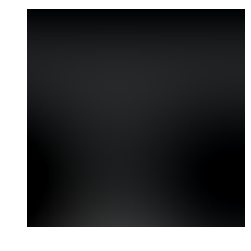

In [40]:
image = np.zeros((100, 100, 3))

#import noise
#help(noise)

# persistence: [0,1]
def perlinNoise(image, scale, octaves, persistence, lacunarity):
  width = image.shape[0]
  height = image.shape[1]
  depth = image.shape[2]
  output = np.zeros((width, height, depth))
  base = random.randint(1,100)
  for x in range(0, width):
    for y in range(0, height):
      for z in range(0, depth):
        output[x][y][z] = pnoise3(x/scale, y/scale, z/scale, octaves=octaves, 
                                persistence=persistence, lacunarity=lacunarity,
                                base=base)
  return output

out = perlinNoise(image, 100.0, 10, 0.4, 0.5)
plotImage(out)

#### Estrutura da árvore

In [81]:
# input e output => np.array 
pset = gp.PrimitiveSetTyped("main", [np.ndarray, float], np.ndarray)
#pset.renameArguments(ARG0="input")
pset.addPrimitive(perlinNoise, [np.ndarray, float, float, float, float], np.ndarray)
pset.addTerminal(10, float)

creator.create("Individual", gp.PrimitiveTree)
toolbox = base.Toolbox()
#toolbox.register("perlinNoise", perlinNoise, np.ndarray, float, float, float, float)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
expr = toolbox.individual()
tree = gp.PrimitiveTree(expr)
print(tree)
#plotTree(expr)



perlinNoise(ARG0, ARG1, ARG1, ARG1, 10)


/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
